# Is it beneficial to discount products?


Import datasets (the order could be changed later depending on when we need each dataset)

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Original Datasets

# orders.csv
url = "https://drive.google.com/file/d/1Vu0q91qZw6lqhIqbjoXYvYAQTmVHh6uZ/view?usp=sharing" 
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
orders = pd.read_csv(path)

# orderlines.csv
url = "https://drive.google.com/file/d/1FYhN_2AzTBFuWcfHaRuKcuCE6CWXsWtG/view?usp=sharing" 
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
orderlines = pd.read_csv(path)

# products.csv
url = "https://drive.google.com/file/d/1afxwDXfl-7cQ_qLwyDitfcCx3u7WMvkU/view?usp=sharing" 
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
products = pd.read_csv(path)

# brands.csv
url = "https://drive.google.com/file/d/1m1ThDDIYRTTii-rqM5SEQjJ8McidJskD/view?usp=sharing" 
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
brands = pd.read_csv(path)

### How should products be classified into different categories to simplify reports 
and analysis?

  1. Discounted products / Not discounted products
  2. Cheap/Medium/Expensive products
  3. Customers buying Cheap/Medium/Expensive products

In [ ]:
# Remove the rows with other than 'Completed' from orders dataset
complete_orders = orders.loc[orders.state == 'Completed']

# Inner join the two datasets complete_orders, orderlines together (in order to do so, set order_id & id_order as index)
orderlines.rename(columns={'id_order': 'order_id'}, inplace=True)
combined_orders = complete_orders.set_index('order_id').join(orderlines.set_index('order_id'), how='inner')
combined_orders.reset_index(inplace=True)

# Inner join the dataframe with products using sku as a key & remove the rows with two dots in either price or unit_price column
combined_orders_filtered = combined_orders.set_index('sku').join(products.set_index('sku'), how='inner')
combined_orders_filtered = combined_orders_filtered[(combined_orders_filtered.price.astype(str).str.contains("\d+\.\d+\.\d+") == False) & 
                                                    (combined_orders_filtered.unit_price.astype(str).str.contains("\d+\.\d+\.\d+") == False)]
combined_orders_filtered.reset_index(inplace=True)

# Convert the data types into the right ones & Calculate the total unit price
combined_orders_filtered["price"] = pd.to_numeric(combined_orders_filtered["price"])
combined_orders_filtered["unit_price"] = pd.to_numeric(combined_orders_filtered["unit_price"])
combined_orders_filtered["created_date"] = pd.to_datetime(combined_orders_filtered["created_date"])
combined_orders_filtered["created_date"] = combined_orders_filtered["created_date"].dt.date
combined_orders_filtered["created_date"] = pd.to_datetime(combined_orders_filtered["created_date"])
combined_orders_filtered["unit_price_total"] = combined_orders_filtered["unit_price"] * combined_orders_filtered["product_quantity"]

# Keep only the columns which are relevant for our question and store it separately
organized_orders = combined_orders_filtered[["order_id", "name", "sku", "price", "unit_price", "product_quantity", "total_paid", "unit_price_total" , "created_date"]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

In [ ]:
# Add the brand information to the dataframe
organized_orders_with_brand = organized_orders[organized_orders.sku.str[:3].isin(brands.short)]
organized_orders_with_brand["short"] = organized_orders_with_brand.sku.str[:3]
organized_orders_with_brand = organized_orders_with_brand.set_index('short').join(brands.set_index('short'), how='left')
organized_orders_with_brand.reset_index(inplace=True)

# Drop the rows with NA values
organized_orders_with_brand.dropna(inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### What is the distribution of product prices across different categories?
  4. Based on the sales (e.g. if cheap products were sold more than expensive products)

###  How many products are being discounted?

  5. Did discout result in the increase of those products?




In [ ]:
# Calculate the discounted amount for each row of data
organized_orders_with_brand["discount"] = organized_orders_with_brand["price"] - organized_orders_with_brand["unit_price"]
# Remove the rows with negative value in discount/discount_rate (As they are not discounted)
organized_orders_with_brand = organized_orders_with_brand[organized_orders_with_brand.discount >= 0]

# Calculate the discount percentage over the original price
organized_orders_with_brand["discount_rate"] = organized_orders_with_brand["discount"] / organized_orders_with_brand["price"] * 100

# Add a new column indicating whether products for each order was discounted at the moment of order
organized_orders_with_brand.loc[organized_orders_with_brand['discount'] > 0, 'sale'] = 'discounted'
organized_orders_with_brand.loc[organized_orders_with_brand['discount'] == 0, 'sale'] = 'not discounted'

organized_orders_with_brand.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

,short,order_id,name,sku,price,unit_price,product_quantity,total_paid,unit_price_total,created_date,long,discount,discount_rate,sale
0,8MO,406520,Open - Micro SD Adapter 8Mobility iSlice Macbo...,8MO0001-A,35.0,12.96,1,16.95,12.96,2017-09-29,8Mobility,22.04,62.971429,discounted
1,8MO,523426,Open - 8Mobility iSlice Micro SD adapter for M...,8MO0003-A,35.0,12.85,1,17.84,12.85,2018-03-08,8Mobility,22.15,63.285714,discounted
2,8MO,347721,8Mobility iSlice Micro SD adapter for Macbook ...,8MO0007,35.0,23.99,1,23.99,23.99,2017-04-20,8Mobility,11.01,31.457143,discounted
3,8MO,347814,8Mobility iSlice Micro SD adapter for Macbook ...,8MO0007,35.0,23.99,1,53.98,23.99,2017-04-21,8Mobility,11.01,31.457143,discounted
4,8MO,348319,8Mobility iSlice Micro SD adapter for Macbook ...,8MO0007,35.0,23.99,1,23.99,23.99,2017-04-21,8Mobility,11.01,31.457143,discounted


In [ ]:
len(organized_orders_with_brand.order_id.unique())

42465

In [ ]:
organized_orders_with_brand.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56345 entries, 0 to 58030
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   short             56345 non-null  object        
 1   order_id          56345 non-null  int64         
 2   name              56345 non-null  object        
 3   sku               56345 non-null  object        
 4   price             56345 non-null  float64       
 5   unit_price        56345 non-null  float64       
 6   product_quantity  56345 non-null  int64         
 7   total_paid        56345 non-null  float64       
 8   unit_price_total  56345 non-null  float64       
 9   created_date      56345 non-null  datetime64[ns]
 10  long              56345 non-null  object        
 11  discount          56345 non-null  float64       
 12  discount_rate     56345 non-null  float64       
 13  sale              56345 non-null  object        
dtypes: datetime64[ns](1), 

In [ ]:
# Count the number of rows with discounted products & its discount percentage
number_of_discounted = len(organized_orders_with_brand[organized_orders_with_brand['sale'] == 'discounted'])
percentage_of_discounted = len(organized_orders_with_brand[organized_orders_with_brand['sale'] == 'discounted']) / len(organized_orders_with_brand) * 100

number_of_discounted, percentage_of_discounted

(53902, 95.66421155382021)

Text(0, 0.5, 'Total Unit Price')

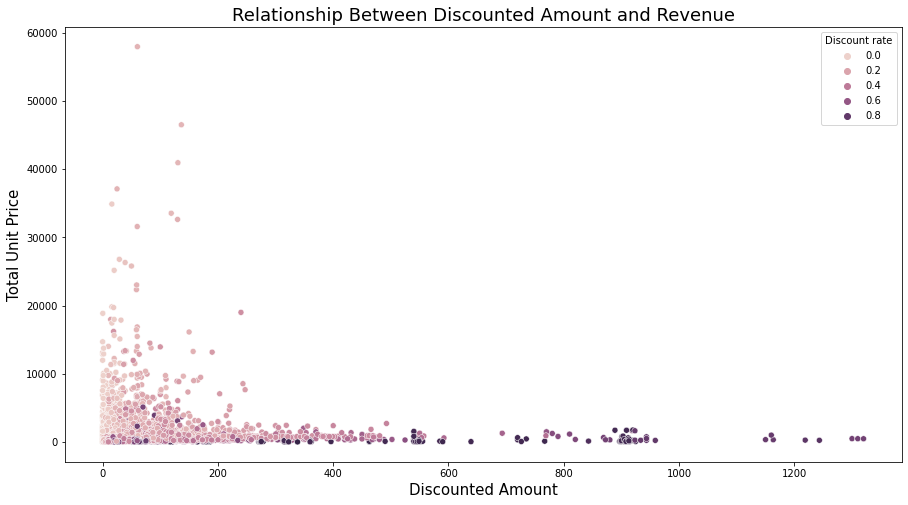

In [ ]:
# Create a dataframe for plotting the relationship between the discounted amount and revenue from ordered products
discount_and_revenue = organized_orders_with_brand.groupby(['sku', 'price', 'discount'])["unit_price_total"].sum().reset_index()

plt.figure(figsize = (15,8))
discount_rate = discount_and_revenue.eval("discount / price").rename("Discount rate")
sns.scatterplot(data=discount_and_revenue, x="discount", y="unit_price_total", hue=discount_rate)
plt.title("Relationship Between Discounted Amount and Revenue", fontsize=18)
plt.xlabel("Discounted Amount", fontsize=15)
plt.ylabel("Total Unit Price", fontsize=15)

### How big are the offered discounts as a percentage of the product prices?

In [ ]:
# Calculate the average discount percentage (excluding those that were not discounted)

average_discount_rate = organized_orders_with_brand[organized_orders_with_brand['sale'] == 'discounted']['discount_rate'].mean()
average_discount_rate

23.684599427406017

### How do seasonality and special dates affect sales?
special dates: Black Friday, Christmas, around the beginning/end of the year

Text(0, 0.5, 'Total Revenue')

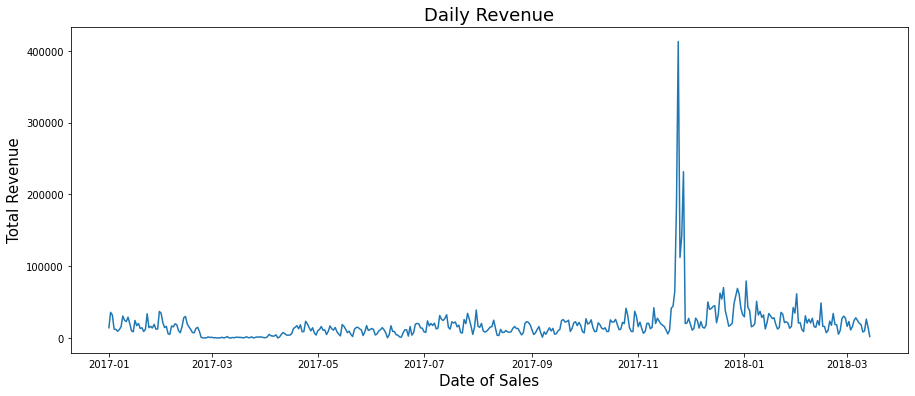

In [ ]:
# Create a dataframe showing daily revenue
daily_revenue = organized_orders_with_brand.groupby(['created_date'])['unit_price_total'].sum().reset_index()

# Plot a lineplot throughout the entire time
plt.figure(figsize = (15,6))
sns.lineplot(data=daily_revenue,
             x='created_date',
             y='unit_price_total')
plt.title("Daily Revenue", fontsize=18)
plt.xlabel("Date of Sales", fontsize=15)
plt.ylabel("Total Revenue", fontsize=15)

Text(0, 0.5, 'Average Discount Rate')

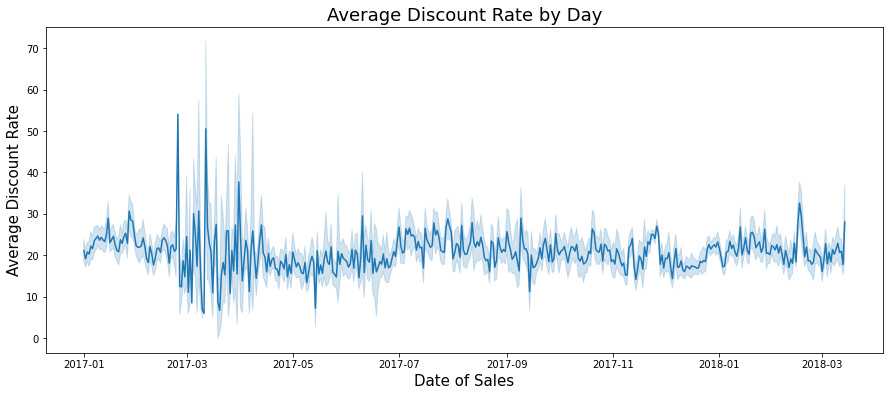

In [ ]:
# Create a dataframe showing average discount_rate by each day & product(sku) in order to compare the pattern of sales & discount
# Note: here, the sku was also taken into consideration
daily_discount = organized_orders_with_brand.groupby(['created_date', 'sku'])['discount_rate'].mean().reset_index()

# Plot a lineplot throughout the entire time
plt.figure(figsize = (15,6))
sns.lineplot(data=daily_discount,
             x='created_date',
             y='discount_rate')
plt.title("Average Discount Rate by Day", fontsize=18)
plt.xlabel("Date of Sales", fontsize=15)
plt.ylabel("Average Discount Rate", fontsize=15)

In [ ]:
# Divide the created_date by week starting from Monday to Sunday
daily_revenue['week'] = pd.to_datetime(daily_revenue['created_date']) - pd.to_timedelta(7, unit='d')
# Calculate mean of daily revenues, grouped by week (Note: The very first and last weeks do not have data for the complete week.)
weekly_revenue = daily_revenue.groupby([pd.Grouper(key='week', freq='W')])['unit_price_total'].sum().reset_index()

# Divide the created_date by week starting from Monday to Sunday
daily_discount['week'] = pd.to_datetime(daily_discount['created_date']) - pd.to_timedelta(7, unit='d')
# Calculate mean of daily discounts, grouped by week (Note: The very first and last weeks do not have data for the complete week.)
weekly_discount = daily_discount.groupby([pd.Grouper(key='week', freq='W')])['discount_rate'].mean().reset_index()

# Replace the week columns in both weekly_revenue and weekly_discount with the week number
weekly_revenue['week'] = np.arange(len(weekly_revenue))
weekly_discount['week'] = np.arange(len(weekly_discount))

Text(0, 0.5, 'Average Discount Rate of the Week')

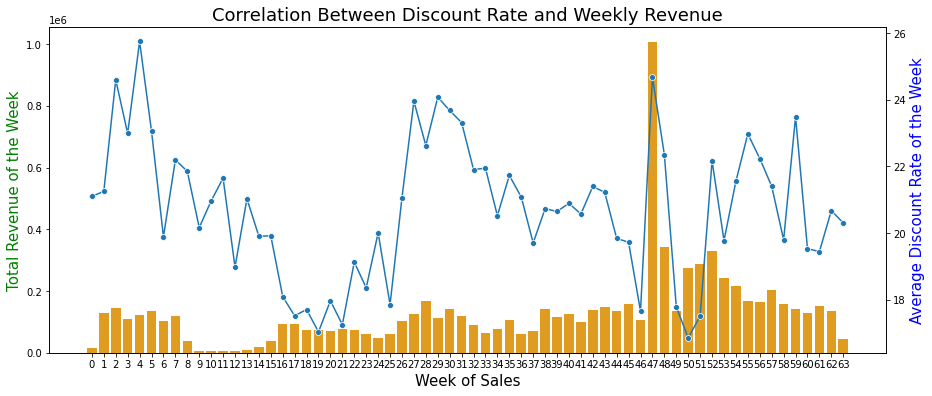

In [ ]:
# Draw a line plot with average discount rate and bar plots with weekly revenue on the same plot
fig, ax1 = plt.subplots(figsize=(15,6)) # initializes figure and plots
sns.barplot(data=weekly_revenue, x='week', y='unit_price_total', ax = ax1, color='orange') # plots the first set of data, and sets it to ax1. 

ax2 = ax1.twinx() # applies twinx to ax2, which is the second y axis. 
sns.lineplot(data=weekly_discount, x='week', y='discount_rate', marker = 'o', ax = ax2) # plots the second set, and sets to ax2. 

# these lines add the annotations for the plot. 
plt.title('Correlation Between Discount Rate and Weekly Revenue', fontsize=18)
ax1.set_xlabel('Week of Sales', fontsize=15)
ax1.set_ylabel('Total Revenue of the Week', color='g', fontsize=15)
ax2.set_ylabel('Average Discount Rate of the Week', color='b', fontsize=15)

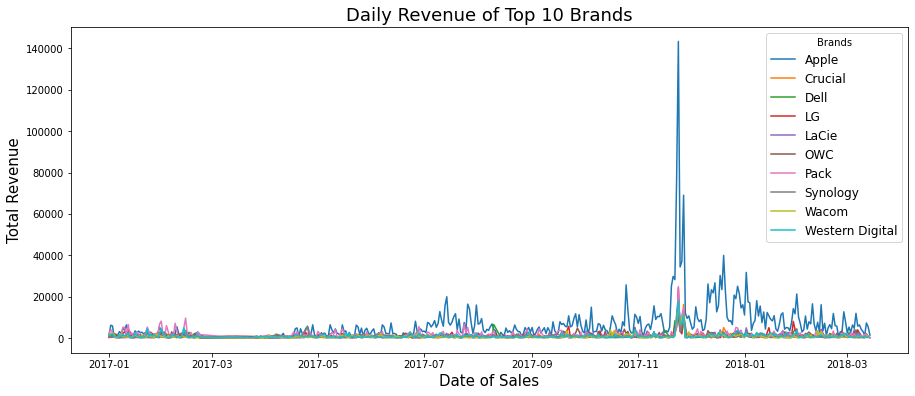

In [ ]:
# Find out top 10 brands with the most revenue
most_revenue_brands = organized_orders_with_brand.groupby(['long'])["unit_price_total"].sum().nlargest(10).index

# Select out the orders only with products from those top brands
most_revenue_sales = organized_orders_with_brand[organized_orders_with_brand["long"].isin(most_revenue_brands) == True]

# Sum up the unit_price_total for each day
most_revenue_daily_sales = most_revenue_sales.groupby(['long', 'created_date'])["unit_price_total"].sum().reset_index()

plt.figure(figsize = (15,6))
sns.lineplot(data=most_revenue_daily_sales,
             x='created_date',
             y='unit_price_total',
             hue='long')
plt.title("Daily Revenue of Top 10 Brands", fontsize=18)
plt.xlabel("Date of Sales", fontsize=15)
plt.ylabel("Total Revenue", fontsize=15)
plt.legend(title="Brands", fontsize=12)

In [ ]:
# Find out periods with highest discount percentage
most_discount_days = organized_orders_with_brand.groupby(['created_date'])["discount_rate"].mean().nlargest(30).index
most_discount_days = pd.to_datetime(most_discount_days).sort_values()
most_discount_days

DatetimeIndex(['2017-01-05', '2017-01-13', '2017-01-15', '2017-01-27',
               '2017-01-28', '2017-01-29', '2017-02-24', '2017-03-01',
               '2017-03-05', '2017-03-08', '2017-03-12', '2017-03-24',
               '2017-03-31', '2017-04-12', '2017-04-21', '2017-06-10',
               '2017-07-05', '2017-07-06', '2017-07-07', '2017-07-28',
               '2017-07-29', '2017-08-12', '2017-09-09', '2017-10-20',
               '2017-12-22', '2018-01-12', '2018-01-13', '2018-02-16',
               '2018-02-17', '2018-03-14'],
              dtype='datetime64[ns]', name='created_date', freq=None)

In [ ]:
# Select out the time and the brand when the revenue was at highest
most_revenue = organized_orders_with_brand[(organized_orders_with_brand.long == 'Apple') & (organized_orders_with_brand.created_date.between("2017-11-01", "2018-01-31"))]

# First, calculate the average discount rate after grouping by order_id (to make sure the ordered items are not overlapped) and again calculate the average discount rate
most_revenue_average_discount = most_revenue.groupby(['order_id'])['discount_rate'].mean().mean()
most_revenue_average_discount # 15.39% (not necessarily higher than the average discount rate overall...)

15.390244306198635

In [ ]:
most_revenue.groupby(['created_date', 'order_id'])[['unit_price_total', 'discount_rate']]

,short,order_id,name,sku,price,unit_price,product_quantity,total_paid,unit_price_total,created_date,long,discount,discount_rate,sale
653,AP2,454884,"Apple iMac 215 ""Core i5 Quad-Core 16GHz | 8GB ...",AP20030,1279.0,965.59,1,965.59,965.59,2017-12-04,Apple,313.41,24.504300,discounted
654,AP2,429687,Like new - Apple iPhone 5S 16GB Silver,AP20055,409.0,189.05,1,194.04,189.05,2017-11-20,Apple,219.95,53.777506,discounted
655,AP2,475918,Like new - Apple iPhone 5S 16GB Silver,AP20055,409.0,199.00,1,203.99,199.00,2017-12-29,Apple,210.00,51.344743,discounted
656,AP2,477119,Like new - Apple iPhone 5S 16GB Silver,AP20055,409.0,199.00,1,404.99,199.00,2017-12-30,Apple,210.00,51.344743,discounted
658,AP2,430177,Like new - Apple iPhone 5s 16GB Space Gray,AP20057,409.0,189.05,1,194.04,189.05,2017-11-21,Apple,219.95,53.777506,discounted
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11940,APP,450891,"Apple iPad Smart Cover Case Pro 105 ""Violeta",APP2624,59.0,56.00,1,65.99,56.00,2017-11-28,Apple,3.00,5.084746,discounted
11941,APP,446092,"Apple iPad Smart Cover Case Pro 105 ""Red Rosa",APP2625,59.0,50.40,1,54.39,50.40,2017-11-26,Apple,8.60,14.576271,discounted
11942,APP,466974,"Apple iPad Smart Cover Case Pro 105 ""Red Rosa",APP2625,59.0,56.00,1,56.00,56.00,2017-12-19,Apple,3.00,5.084746,discounted
11943,APP,423365,Apple Smart Cover iPad Case Red,APP2629,45.0,42.00,1,1774.99,42.00,2017-11-08,Apple,3.00,6.666667,discounted


In [ ]:
# Draw a line plot with average discount rate and bar plots with weekly revenue on the same plot
fig, ax1 = plt.subplots(figsize=(15,6)) # initializes figure and plots
sns.barplot(data=most_revenue, x='created_date', y='unit_price_total', ax = ax1, color='orange') # plots the first set of data, and sets it to ax1. 

ax2 = ax1.twinx() # applies twinx to ax2, which is the second y axis. 
sns.lineplot(data=most_revenue, x='created_date', y='discount_rate', marker = 'o', ax = ax2) # plots the second set, and sets to ax2. 

# these lines add the annotations for the plot. 
plt.title('Sales of Apple Products between November 2017 and February 2018', fontsize=18)
ax1.set_xlabel('Date of Sales', fontsize=15)
ax1.set_ylabel('Total Revenue of the Week', color='g', fontsize=15)
ax2.set_ylabel('Average Discount Rate of the Week', color='b', fontsize=15)

### How could data collection be improved?

In [ ]:
# Less mistakes in the unit. For example, we could not use the values in the promo_price column because of two dots in over 40% of the data.
# More information about the profit from each product would be great in order to calculate the overall profit that is closer to the actual profit of the company.